In [1]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import json
from matplotlib import colors
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Generic methods to convert json format to DataFrame

In [49]:
def compute_metrics(data : dict):
    oc_list = list()
    available_list = list()
    prev_available_list = list()
    deltabooked_list = list()
    correction_list = list()
    percentile_list = list()
    prev_percentile_list = list()
    config_list = list()
    prev_booked = 0
    prev_available = 0
    prev_percentile = 0
    for index in range(len(data["epoch"])):
        available = data["model"]["free_cpu"][index]
        config = data['node']["cpu_config"][index]
        ratio = (data['node']["booked_cpu"][index] + data["model"]["free_cpu"][index])/data['node']["cpu_config"][index]
        percentile = data['node']['cpu_percentile'][index]['99'] 
        delta_booked = data['node']["booked_cpu"][index] - prev_booked
        oc_list.append(ratio)
        available_list.append(available)
        prev_available_list.append(prev_available)
        deltabooked_list.append(delta_booked)
        if delta_booked>=0:
            correction_list.append(delta_booked)
        else:
            correction_list.append(percentile - prev_percentile)
        percentile_list.append(percentile)
        prev_percentile_list.append(prev_percentile)
        config_list.append(config)
        prev_available = available
        prev_percentile = percentile
        prev_booked = data['node']["booked_cpu"][index]
    return oc_list, available_list, prev_available_list, deltabooked_list, correction_list, percentile_list, prev_percentile_list, config_list

def add_line(dict_to_use : dict, curr_strategy, curr_iteration, oc_ratio, available, prev_available, delta_booked, correction, percentile, prev_percentile, config):
    dict_to_use["strategy"].append(curr_strategy)
    dict_to_use["iteration"].append(curr_iteration)
    dict_to_use["ratio"].append(oc_ratio)
    dict_to_use["available"].append(available)
    dict_to_use["prev_available"].append(prev_available)
    dict_to_use["delta_booked"].append(delta_booked)
    dict_to_use["correction"].append(correction)
    dict_to_use["percentile"].append(percentile)
    dict_to_use["prev_percentile"].append(prev_percentile)
    dict_to_use["config"].append(config)

def convert_res_to_cumul(input_df : pd.DataFrame):
    pd.options.mode.chained_assignment = None 
    
    cumul_res_dic= dict()
    cumul_res_dic['strategy'] = list()
    cumul_res_dic['iteration'] = list()
    cumul_res_dic['violation_cumulated'] = list()
    cumul_res_dic['violation_cumulated%'] = list()
    cumul_res_dic['misprediction_cumulated'] = list()
    cumul_res_dic['misprediction_cumulated%'] = list()
    cumul_res_dic['decreases_cumulated'] = list()
    cumul_res_dic['decreases_cumulated%'] = list()

    for strategy in list(input_df['strategy'].unique()):

        x = input_df.loc[input_df['strategy'] ==  strategy]
        x['violation'] = x['current_available_misprediction'].apply(lambda x : np.abs(x) if x < 0 else 0)
        x['misprediction'] = x['current_available_misprediction'].apply(lambda x : np.abs(x))
        x['decreases'] = x['delta_available'].apply(lambda x : np.abs(x) if x < 0 else 0)

        iteration_list = list()
        violation_cumulated_list = list()
        violation_cumulated_val = 0
        misprediction_cumulated_list = list()
        misprediction_cumulated_val = 0
        decreases_cumulated_list = list()
        decreases_cumulated_val = 0
        for index, row in x.iterrows():
            iteration_list.append(row['iteration'])
            violation_cumulated_val += row['violation']
            violation_cumulated_list.append(violation_cumulated_val)
            misprediction_cumulated_val += row['misprediction']
            misprediction_cumulated_list.append(misprediction_cumulated_val)
            decreases_cumulated_val += row['decreases']
            decreases_cumulated_list.append(decreases_cumulated_val)

        cumul_res_dic['iteration'].extend(iteration_list)
        cumul_res_dic['strategy'].extend([strategy for val in iteration_list])
        cumul_res_dic['violation_cumulated'].extend(violation_cumulated_list)
        cumul_res_dic['violation_cumulated%'].extend([(x - np.min(violation_cumulated_list))/(np.max(violation_cumulated_list)-np.min(violation_cumulated_list)) for x in violation_cumulated_list])
        cumul_res_dic['misprediction_cumulated'].extend(misprediction_cumulated_list)
        cumul_res_dic['misprediction_cumulated%'].extend([(x - np.min(misprediction_cumulated_list))/(np.max(misprediction_cumulated_list)-np.min(misprediction_cumulated_list)) for x in misprediction_cumulated_list])
        cumul_res_dic['decreases_cumulated'].extend(decreases_cumulated_list)
        cumul_res_dic['decreases_cumulated%'].extend([(x - np.min(decreases_cumulated_list))/(np.max(decreases_cumulated_list)-np.min(decreases_cumulated_list)) for x in decreases_cumulated_list])
    
    return pd.DataFrame(cumul_res_dic)

def load_folder(folder : str):
    input_strat = dict()
    #strategies = ['borg', 'doa', 'greedy', 'maxpeak', 'nsigma', 'percentile', 'rclike']
    strategies = ['greedy', 'greedy2', 'greedy3', 'greedy4', 'greedy5', 'greedy6']
    for strategy in strategies:
        input_strat[strategy] = folder + "/dump-" + strategy + ".json"
    
    compare_strat_dict = dict()
    compare_strat_dict["iteration"] = list()
    compare_strat_dict["strategy"] = list()
    compare_strat_dict["ratio"] = list()
    compare_strat_dict["available"] = list()
    compare_strat_dict["prev_available"] = list()
    compare_strat_dict["percentile"] = list()
    compare_strat_dict["delta_booked"] = list()
    compare_strat_dict["correction"] = list()
    compare_strat_dict["prev_percentile"] = list()
    compare_strat_dict["config"] = list()
    
    for strat, file in input_strat.items():
        print("Loading", strat, file)
        with open(file, 'r') as f:
            targeted_data = json.load(f)
        oc_list, available_list, prev_available_list, deltabooked_list, correction_list, percentile_list, prev_percentile_list, config_list = compute_metrics(targeted_data)
        for iteration_curr in range(len(oc_list)):
            add_line(compare_strat_dict, strat, iteration_curr, oc_list[iteration_curr], available_list[iteration_curr], prev_available_list[iteration_curr], deltabooked_list[iteration_curr], correction_list[iteration_curr], percentile_list[iteration_curr], prev_percentile_list[iteration_curr], config_list[iteration_curr])
    print("Done")
    
    return compare_strat_dict

# Load the "decreasing workload" trace

In [50]:
folder = "/usr/local/src/scroogevm/dump-decrease"

decreasing_df = pd.DataFrame(load_folder(folder))

Loading greedy /usr/local/src/scroogevm/dump-decrease/dump-greedy.json
Loading greedy2 /usr/local/src/scroogevm/dump-decrease/dump-greedy2.json
Loading greedy3 /usr/local/src/scroogevm/dump-decrease/dump-greedy3.json
Loading greedy4 /usr/local/src/scroogevm/dump-decrease/dump-greedy4.json
Loading greedy5 /usr/local/src/scroogevm/dump-decrease/dump-greedy5.json
Loading greedy6 /usr/local/src/scroogevm/dump-decrease/dump-greedy6.json
Done


In [51]:
decreasing_df = decreasing_df.loc[decreasing_df["iteration"] < 30]
decreasing_df = decreasing_df.loc[decreasing_df["iteration"] > 0]

decreasing_df["prev_available_corrected"] = decreasing_df["prev_available"] - decreasing_df["correction"]
decreasing_df["available_groundthruth"] = decreasing_df["config"] - decreasing_df["percentile"]
decreasing_df["delta_available"] = decreasing_df["available"] - decreasing_df["prev_available_corrected"]

decreasing_df["current_available_misprediction"] = decreasing_df["available_groundthruth"] - decreasing_df["prev_available_corrected"]
decreasing_df["current_available_misprediction%"] = decreasing_df["current_available_misprediction"] / decreasing_df["config"]

strategies = decreasing_df['strategy'].unique()

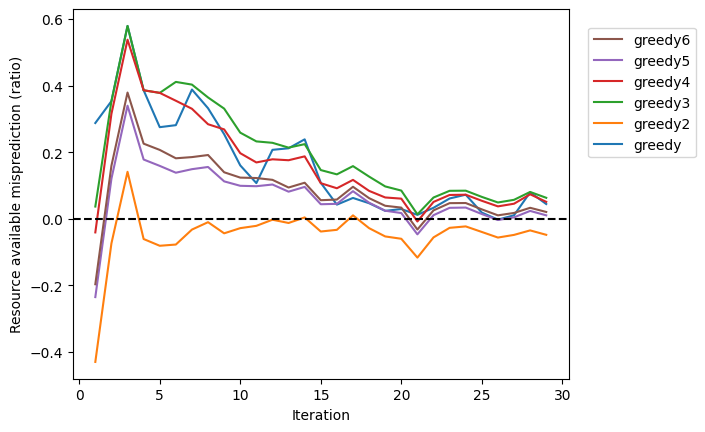

In [52]:
#hue_order = ['percentile', 'greedy', 'doa']
colors = sns.color_palette("husl", 10)

sns.lineplot(data=decreasing_df, x="iteration", y="current_available_misprediction%", hue="strategy") #, palette=[colors[0], colors[5], 'darkorange'], hue_order=hue_order)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Iteration')
x = plt.legend(ncol=1, loc="lower right", frameon=True, reverse=True, bbox_to_anchor=(1.27, 0.58))
x = plt.ylabel('Resource available misprediction (ratio)')

In [53]:
# Avg violation sur avg correction
decreasing_cumul_res_df = convert_res_to_cumul(input_df=decreasing_df)

/tmp/ipykernel_10907/3013594485.py:86: RuntimeWarning: invalid value encountered in scalar divide
  cumul_res_dic['violation_cumulated%'].extend([(x - np.min(violation_cumulated_list))/(np.max(violation_cumulated_list)-np.min(violation_cumulated_list)) for x in violation_cumulated_list])


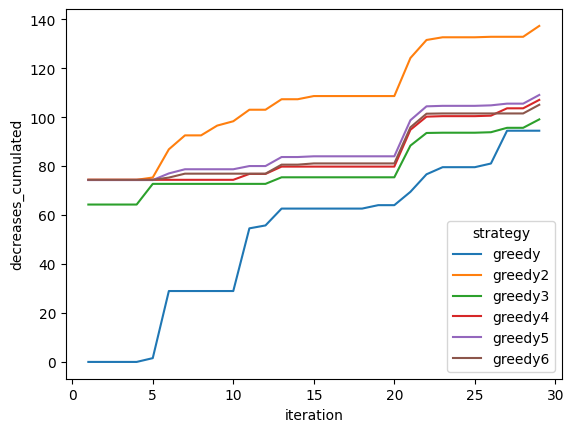

In [54]:
without_doa = decreasing_cumul_res_df # .loc[decreasing_cumul_res_df['strategy'] != 'doa']
g = sns.lineplot(data=without_doa, x="iteration", y="decreases_cumulated", hue="strategy")

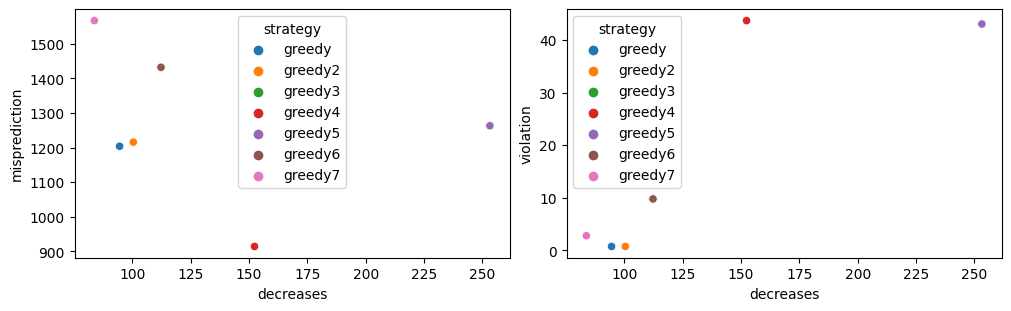

In [218]:
from collections import defaultdict

res_dic = defaultdict(lambda : list())

for strategy in list(decreasing_cumul_res_df['strategy'].unique()):
    
    res_dic['strategy'].append(strategy)
    
    x = decreasing_cumul_res_df.loc[decreasing_cumul_res_df['strategy'] ==  strategy]
    res_dic['misprediction'].append(x['misprediction_cumulated'].max())
    res_dic['violation'].append(x['violation_cumulated'].max())
    res_dic['decreases'].append(x['decreases_cumulated'].max())
    
res_df = pd.DataFrame(res_dic)

fig, axs = plt.subplots(1, 2, figsize=(10,3), layout='constrained')

x = sns.scatterplot(res_df, x='decreases', y='misprediction', hue='strategy', ax=axs[0])
x = sns.scatterplot(res_df, x='decreases', y='violation', hue='strategy', ax=axs[1])

# Load the "increasing workload" trace

In [176]:
folder = "/usr/local/src/scroogevm/dump-increase"

increasing_df = pd.DataFrame(load_folder(folder))

Loading borg /usr/local/src/scroogevm/dump-increase/dump-borg.json
Loading doa /usr/local/src/scroogevm/dump-increase/dump-doa.json
Loading greedy /usr/local/src/scroogevm/dump-increase/dump-greedy.json
Loading maxpeak /usr/local/src/scroogevm/dump-increase/dump-maxpeak.json
Loading nsigma /usr/local/src/scroogevm/dump-increase/dump-nsigma.json
Loading percentile /usr/local/src/scroogevm/dump-increase/dump-percentile.json
Loading rclike /usr/local/src/scroogevm/dump-increase/dump-rclike.json
Done


In [177]:
increasing_df = increasing_df.loc[increasing_df["iteration"] < 30]
increasing_df = increasing_df.loc[increasing_df["iteration"] > 0]

increasing_df["prev_available_corrected"] = increasing_df["prev_available"] - increasing_df["correction"]
increasing_df["delta_available"] = increasing_df["available"] - increasing_df["prev_available_corrected"]
increasing_df["current_available"] = increasing_df["config"] - increasing_df["percentile"]

increasing_df["current_available_misprediction"] = increasing_df["current_available"] - increasing_df["prev_available_corrected"]
increasing_df["current_available_misprediction%"] = increasing_df["current_available_misprediction"] / increasing_df["config"]

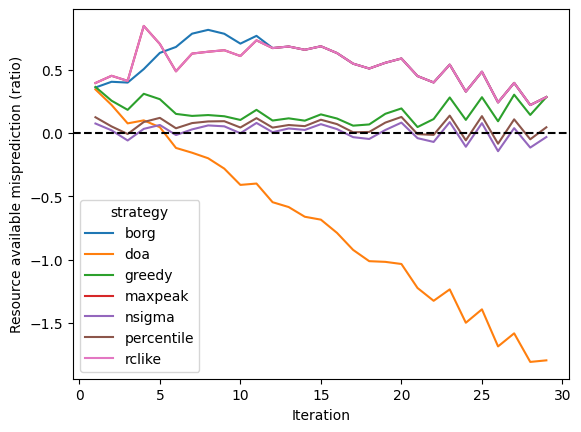

In [178]:
#hue_order = ['percentile', 'greedy', 'doa']
colors = sns.color_palette("husl", 10)

sns.lineplot(data=increasing_df, x="iteration", y="current_available_misprediction%", hue="strategy") # , palette=[colors[0], colors[5], 'darkorange'], hue_order=hue_order)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Iteration')
x = plt.ylabel('Resource available misprediction (ratio)')

Strategy borg negative variation count: 0 average: nan max nan
Strategy doa negative variation count: 1 average: -87.0 max -87.0
Strategy greedy negative variation count: 4 average: -3.9500000000000046 max -6.1000000000000085
Strategy maxpeak negative variation count: 2 average: -44.900000000000006 max -83.2
Strategy nsigma negative variation count: 0 average: nan max nan
Strategy percentile negative variation count: 0 average: nan max nan
Strategy rclike negative variation count: 2 average: -44.900000000000006 max -83.2


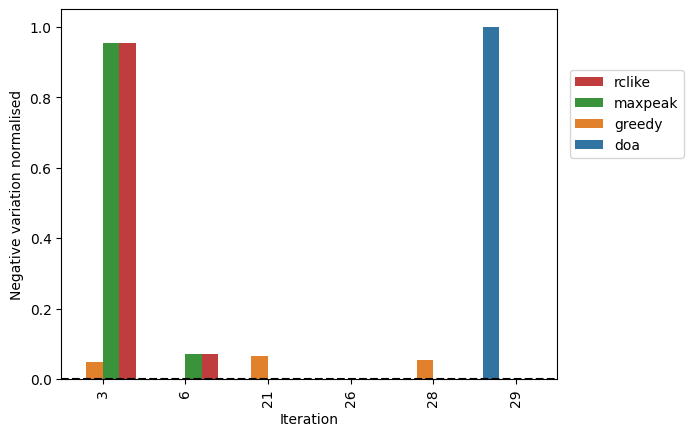

In [179]:
pd.options.mode.chained_assignment = None 
filter_df = increasing_df.loc[increasing_df['delta_available'] < 0]
min_val = filter_df['delta_available'].min()
max_val = filter_df['delta_available'].max()
filter_df['delta_available_norm'] = filter_df['delta_available'].apply(lambda x : (x - max_val) / (min_val - max_val))

sns.barplot(data=filter_df, x="iteration", y="delta_available_norm", hue="strategy")
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Iteration')
x = plt.legend(ncol=1, loc="lower right", frameon=True, reverse=True, bbox_to_anchor=(1.27, 0.58))
x = plt.ylabel('Negative variation normalised')
x = plt.xticks(rotation=90)

strategies = increasing_df['strategy'].unique()
for strategy in strategies:
    filter_strategy_df = filter_df.loc[filter_df['strategy'] ==  strategy]
    st_mean = filter_strategy_df['delta_available'].mean()
    st_max = filter_strategy_df['delta_available'].min()
    print("Strategy", strategy, "negative variation count:", len(filter_strategy_df), "average:", st_mean, "max", st_max)

In [180]:
increasing_cumul_res_df = convert_res_to_cumul(input_df=increasing_df)

/tmp/ipykernel_9374/2951736795.py:86: RuntimeWarning: invalid value encountered in scalar divide
  cumul_res_dic['violation_cumulated%'].extend([(x - np.min(violation_cumulated_list))/(np.max(violation_cumulated_list)-np.min(violation_cumulated_list)) for x in violation_cumulated_list])
/tmp/ipykernel_9374/2951736795.py:90: RuntimeWarning: invalid value encountered in scalar divide
  cumul_res_dic['decreases_cumulated%'].extend([(x - np.min(decreases_cumulated_list))/(np.max(decreases_cumulated_list)-np.min(decreases_cumulated_list)) for x in decreases_cumulated_list])
/tmp/ipykernel_9374/2951736795.py:86: RuntimeWarning: invalid value encountered in scalar divide
  cumul_res_dic['violation_cumulated%'].extend([(x - np.min(violation_cumulated_list))/(np.max(violation_cumulated_list)-np.min(violation_cumulated_list)) for x in violation_cumulated_list])
/tmp/ipykernel_9374/2951736795.py:86: RuntimeWarning: invalid value encountered in scalar divide
  cumul_res_dic['violation_cumulated%']

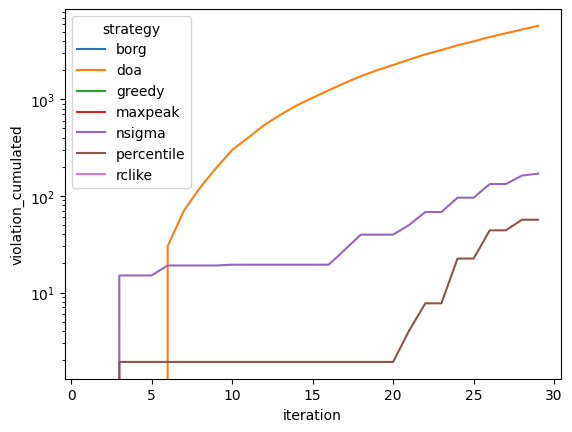

In [181]:
without_doa = increasing_cumul_res_df # .loc[decreasing_cumul_res_df['strategy'] != 'doa']
g = sns.lineplot(data=without_doa, x="iteration", y="violation_cumulated", hue="strategy")
g.set_yscale('log')

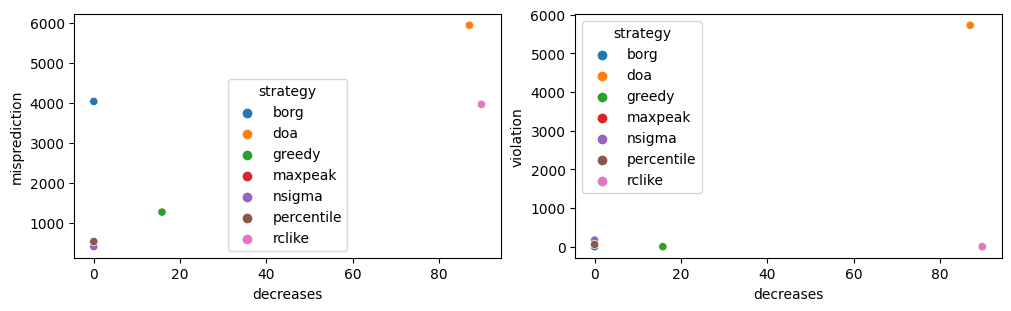

In [175]:
from collections import defaultdict

res_dic = defaultdict(lambda : list())

for strategy in list(increasing_cumul_res_df['strategy'].unique()):
    
    res_dic['strategy'].append(strategy)
    
    x = increasing_cumul_res_df.loc[increasing_cumul_res_df['strategy'] ==  strategy]
    res_dic['misprediction'].append(x['misprediction_cumulated'].max())
    res_dic['violation'].append(x['violation_cumulated'].max())
    res_dic['decreases'].append(x['decreases_cumulated'].max())
    
res_df = pd.DataFrame(res_dic)

fig, axs = plt.subplots(1, 2, figsize=(10,3), layout='constrained')

x = sns.scatterplot(res_df, x='decreases', y='misprediction', hue='strategy', ax=axs[0])
x = sns.scatterplot(res_df, x='decreases', y='violation', hue='strategy', ax=axs[1])

# Compare both traces on the same board (Paper figure)

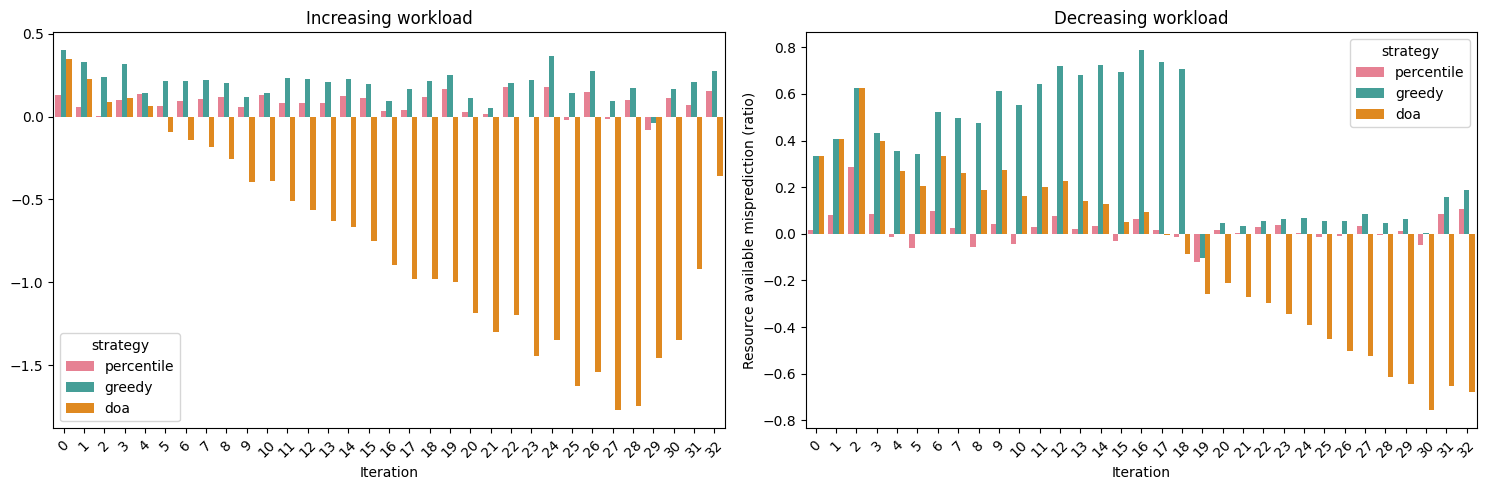

In [46]:
hue_order = ['percentile', 'greedy', 'doa']
colors = sns.color_palette("husl", 10)
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(15, 5))


g = sns.barplot(data=compare_df2, x="iteration", y="current_available_misprediction%", hue="strategy",  palette=[colors[0], colors[5], 'darkorange'], hue_order=hue_order, ax=ax1)
ax1.set_title("Increasing workload")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("")
x = ax1.set_xticklabels(ax1.get_xticks(), rotation=45)

g = sns.barplot(data=compare_df, x="iteration", y="current_available_misprediction%", hue="strategy", palette=[colors[0], colors[5], 'darkorange'], hue_order=hue_order, ax=ax2)
ax2.set_title("Decreasing workload")
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Resource available misprediction (ratio)")
x = ax2.set_xticklabels(ax2.get_xticks(), rotation=45)

fig.tight_layout()